Run batch file to download weather data from the [Danish Meteorological Institute](
https://www.dmi.dk/fileadmin/Rapporter/2024/DMIRep24-08.pdf)

In [ ]:
!cd ../data/air/ & air_download.bat

Load data and calculate anomalies in surface air temperature

In [2]:
import glob
import os

import pandas as pd
import pyproj
import xarray as xr

# Tweak column names based on Table 1 here:
# https://www.dmi.dk/fileadmin/Rapporter/2024/DMIRep24-08.pdf
COL_NAMES = {
    "Station": "station_id",
    "Year": "year",
    "Month": "month",
    "Day": "day",
    "Hour(utc)": "hour",
    "101": "mean_air_temp_degc",
}

# Metadata for final Dataset
GLOBAL_ATTRS = {
    "author": "Jensen, C. D.",
    "institution": "Danish Meteorological Institute (DMI)",
    "projection": "3413",
    "title": "Weather Observations from Greenland 1958-2023",
    "version": "08 February 2024",
    "data_description": "https://www.dmi.dk/fileadmin/Rapporter/2024/DMIRep24-08.pdf",
}
VAR_ATTRS = {
    "x": {
        "description": "x coordinate of projection",
        "units": "metres",
    },
    "y": {
        "description": "y coordinate of projection",
        "units": "metres",
    },
    "glacier": {
        "description": "Initials of glacier name",
    },
    "station_id": {
        "description": "6-digit station number",
    },
    "height": {
        "description": "Height of weather station above mean sea level",
        "units": "metres",
    },
    "temperature": {
        "description": "Monthly mean of hourly mean air temperature, measured 2m above ground",
        "units": "degrees celcius",
    },
    "temperature_anomaly": {
        "description": "Anomaly in monthly mean air temperature calculated relative to the 1988-2024 baseline",
        "units": "degrees celcius",
    },
}

# Collect weather station data files and load station metadata
files = [f for f in glob.glob(f"../data/air/*00.csv")]
station_details = pd.read_excel(f"../data/air/station_metadata.xlsx")

# Container for final Datasets
air_ds = []

# Process weather data for each station in turn
for f in files:
    # Extract station metadata
    station_id = int(os.path.splitext(os.path.basename(f))[0])
    station_meta = (
        station_details.loc[station_details["Station number"] == station_id].sort_values(by="Start date").iloc[-1]
    )
    station_height = station_meta.Height

    # Transform coords to EPSG:3413
    transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3413")
    station_x, station_y = transformer.transform(station_meta.Latitude, station_meta.Longitude)

    # Generate glacier code based on which file is being processed -
    # requires knowledge of which file maps to which site
    glacier = "DAUGAARD-JENSEN" if station_id == 433900 else "UNNAMED_UUNARTIT_ISLANDS"

    # Load weather data and add meaningful label to temperature param
    station_df = pd.read_csv(f, delimiter=";")
    station_df = station_df.rename(columns=COL_NAMES)

    # Construct and set datetime index from individual date and time components
    station_df["time"] = pd.to_datetime(station_df[["year", "month", "day", "hour"]])
    station_df = station_df.set_index("time")

    # Drop unnecessary columns
    station_df = station_df[["station_id", "mean_air_temp_degc"]]

    # Convert DataFrame to xarray.Dataset
    station_ds = station_df.to_xarray()
    station_ds = station_ds.sel(time=slice("2000-01-01", "2024-01-01"))

    # Compute daily average, discarding where there is less than 4 observations
    t_count_daily = station_ds.mean_air_temp_degc.resample(time="1D").count()
    t_mean_daily = station_ds.mean_air_temp_degc.resample(time="1D").mean()
    t_mean_daily = t_mean_daily.where(t_count_daily > 4, drop=True)

    # Compute monthly average, discarding where there is less than 25 observations
    t_count_monthly = t_mean_daily.resample(time="1MS").count()
    t_mean_monthly = t_mean_daily.resample(time="1MS").mean()
    t_mean_monthly = t_mean_monthly.where(t_count_monthly >= 25, drop=True)

    # Define baseline period (period of overlap between data from both stations)
    baseline = slice("2000-01-01", "2024-01-01")

    # Calculate anomalies relative to baseline
    t_baseline = t_mean_monthly.sel(time=baseline).groupby("time.month").mean()
    t_anomalies = t_mean_monthly.groupby("time.month") - t_baseline

    # Merge mean and anomalies into single Dataset
    t_mean_monthly = t_mean_monthly.to_dataset(name="temperature")
    t_anomalies = t_anomalies.drop_vars("month").to_dataset(name="temperature_anomaly")
    _t_ds = xr.combine_by_coords([t_mean_monthly, t_anomalies])

    # Assign station metadata and coordinate/variable attributes
    _t_ds = _t_ds.assign_coords(
        station_id=("station_id", [station_id], VAR_ATTRS["station_id"]),
        glacier=("station_id", [glacier], VAR_ATTRS["glacier"]),
        x=("station_id", [station_x], VAR_ATTRS["x"]),
        y=("station_id", [station_y], VAR_ATTRS["y"]),
        height=("station_id", [station_height], VAR_ATTRS["height"]),
    )
    _t_ds = _t_ds.swap_dims({"station_id": "glacier"})
    _t_ds["temperature"] = _t_ds.temperature.assign_attrs(VAR_ATTRS["temperature"])
    _t_ds["temperature_anomaly"] = _t_ds.temperature_anomaly.assign_attrs(VAR_ATTRS["temperature_anomaly"])
    air_ds.append(_t_ds)

# Merge Datasets station-wise, assign global attributes, and write to disk
air_ds = xr.combine_by_coords(air_ds)
air_ds = air_ds.assign_attrs(GLOBAL_ATTRS)
air_ds.to_netcdf("../data/air/air_temp_monthly_2000_2024.nc")
air_ds

<xarray.Dataset> Size: 12kB
Dimensions:              (glacier: 2, time: 287)
Coordinates:
  * time                 (time) datetime64[ns] 2kB 2000-01-01 ... 2023-12-01
  * glacier              (glacier) <U24 192B 'DAUGAARD-JENSEN' 'UNNAMED_UUNAR...
    station_id           (glacier) int32 8B 433900 435100
    x                    (glacier) float64 16B 8.355e+05 5.363e+05
    y                    (glacier) float64 16B -1.964e+06 -2.377e+06
    height               (glacier) float64 16B 70.0 12.0
Data variables:
    temperature          (glacier, time) float64 5kB -13.46 -14.48 ... -9.602
    temperature_anomaly  (glacier, time) float64 5kB -1.152 -1.201 ... -2.847
Attributes:
    author:            Jensen, C. D.
    institution:       Danish Meteorological Institute (DMI)
    projection:        3413
    title:             Weather Observations from Greenland 1958-2023
    version:           08 February 2024
    data_description:  https://www.dmi.dk/fileadmin/Rapporter/2024/DMIRep24-0...

Surface air temperature anomaly time series at station for Uunartit Islands

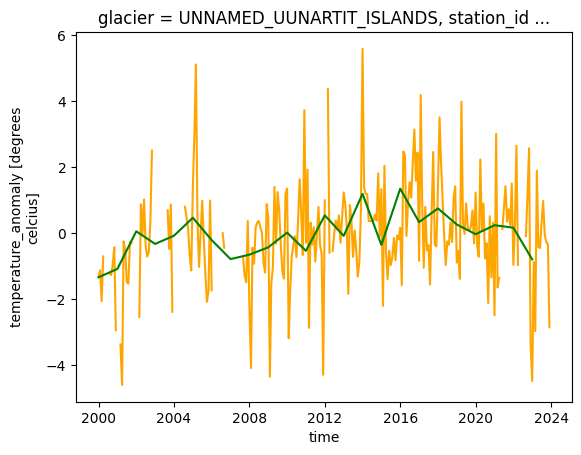

In [3]:
air_ds.isel(glacier=1).temperature_anomaly.plot(color="orange")
air_ds.isel(glacier=1).temperature_anomaly.resample(time="1YS").mean().plot(color="green", zorder=10)

Linear trend

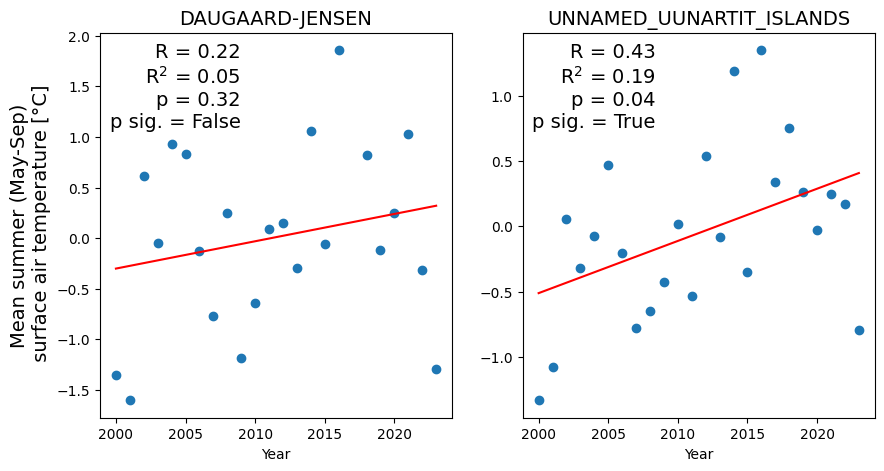

In [6]:
import matplotlib.pyplot as plt
import scipy
import xarray as xr
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

# Set up axes
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(nrows=1, ncols=2, width_ratios=(1, 1))
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
axs = [ax0, ax1]

# Load terminus change data
air_ds = xr.open_dataset(f"../data/air/air_temp_monthly_2000_2024.nc")

for i, (glacier, ds) in enumerate(air_ds.groupby("glacier", squeeze=False)):
    # Resample terminus change to annual means and extract years
    temperature = ds.temperature_anomaly.squeeze()  # .sel(time=ds.temperature.time.dt.month.isin([6, 7, 8]))
    temperature = temperature.resample(time="1YS").mean()
    years = temperature.time.dt.year

    mask = temperature.notnull() & years.notnull()
    temperature = temperature.where(mask, drop=True)
    years = years.where(mask, drop=True)

    # Regress terminus change against year
    res = scipy.stats.linregress(years, temperature)

    # Plot data and trendline
    axs[i].plot(years, temperature, "o")
    axs[i].plot(years, res.intercept + res.slope * years, "r", label="fitted line")

    # Add R2 and p values to plot
    axs[i].add_artist(
        AnchoredText(
            f"R = {res.rvalue:.2f}\nR$^{{2}}$ = {res.rvalue**2:.2f}\np = {res.pvalue:.2f}\np sig. = {res.pvalue < 0.05}",
            loc="upper left",
            borderpad=0.1,
            prop=dict(fontsize=14, horizontalalignment="right"),
            frameon=False,
        )
    )

    # Label plots
    axs[i].set_title(glacier, fontsize=14)
    axs[i].set_xlabel("Year")

axs[0].set_ylabel("Mean summer (May-Sep)\n surface air temperature [\N{DEGREE SIGN}C]", size=14)

plt.show()